In [2]:
import numpy as np
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from confusion_matrix import ConfusionMatrix
import skimage.measure
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score


# Without pooling results

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


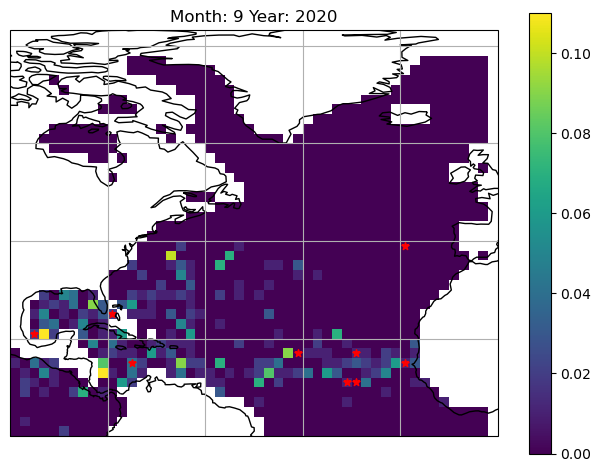

In [3]:
testlabelpoints_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_label_points_obs.nc").__xarray_dataarray_variable__
testprobs_formatted_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/probabilities_prediction.nc").__xarray_dataarray_variable__

# Evaluate RF Model Results
plotmonth = 9
plotyear = 2020

# Figure out observed genesis locations
i1 = np.where(testlabelpoints_open.sel(Month=plotmonth,Year=plotyear) > 0)[0]
i2 = np.where(testlabelpoints_open.sel(Month=plotmonth,Year=plotyear) > 0)[1]
locations = testlabelpoints_open.sel(Month=plotmonth,Year=plotyear)[i1,i2]

# Plot genesis probabilities and locations
gridsize = 2
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines()
genesisplot = ax.pcolormesh(testprobs_formatted_open.Longitude,testprobs_formatted_open.Latitude,testprobs_formatted_open.sel(Month=plotmonth,Year=plotyear),transform=ccrs.PlateCarree())
ax.scatter(locations.Longitude+gridsize/2,locations.Latitude+gridsize/2,transform=ccrs.PlateCarree(),s=30,marker='*',c='r')
ax.set_extent([-100, 0, 0, 80])
plt.colorbar(genesisplot)
plt.title('Month: ' + str(plotmonth) + ' Year: ' + str(plotyear))
plt.savefig('/glade/work/acheung/Initial_RF_Plots/Genesis Plot',dpi=600)
plt.tight_layout()

In [4]:
# # Make POD and FAR Plots

# test_labels = testlabelpoints_open.stack(z=("Month","Latitude","Longitude","Year"))
# test_labels_array = np.asarray(test_labels)
# thresholds = np.arange(0,0.31,0.01)
# genesisprobs = testprobs_formatted_open.stack(z=("Month","Latitude","Longitude","Year"))

# performancelist = []
# for threshloop in thresholds:
#     y_test_pred = genesisprobs >= threshloop
#     y_test_true = test_labels_array > 0
#     confusion = ConfusionMatrix(y_test_true, np.asarray(y_test_pred))
#     performancelist.append([round(confusion.hit_pod(),3),round(confusion.false_alarm_ratio(),3),round(threshloop,2)])

# performancePD = pd.DataFrame(performancelist,columns=['POD','FAR','Threshold'])
# plt.figure()
# plt.plot(performancePD['Threshold'],performancePD['POD'])
# plt.grid()
# plt.ylabel('Probability of Detection')
# plt.xlabel('Threshold')
# plt.savefig('/glade/work/acheung/Initial_RF_Plots/POD.png',dpi=400)


# plt.figure()
# plt.plot(performancePD['Threshold'],performancePD['FAR'])
# plt.grid()
# plt.ylabel('False Alarm Ratio')
# plt.xlabel('Threshold')
# plt.savefig('/glade/work/acheung/Initial_RF_Plots/FAR.png',dpi=400)

# With pooling results

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


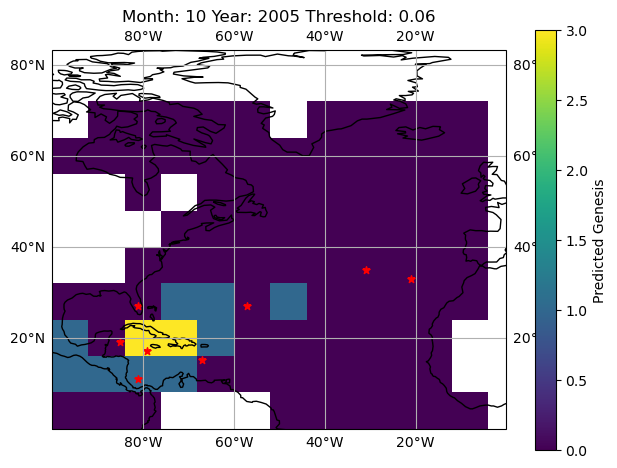

In [5]:
allscores = []
for intervalloop in [4]:
    precision_scores_current_int = []

    for thresholdloop in [0.06]:
        testprobs_formatted_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/probabilities_prediction.nc").__xarray_dataarray_variable__

        interval = intervalloop
        testprobs_formatted_open_alter = testprobs_formatted_open


        threshold_testing = thresholdloop
        prob_boo = testprobs_formatted_open_alter>threshold_testing
        prob_boo_pre_pooling = prob_boo.where(np.isnan(testprobs_formatted_open_alter) == False)

        isnan_pool = xr.DataArray(skimage.measure.block_reduce(np.isnan(testprobs_formatted_open_alter)==False, (1,interval,interval,1),np.nansum),
                     coords=[testprobs_formatted_open_alter.coords['Month'],
                             testprobs_formatted_open_alter.coords['Latitude'][::interval],
                            testprobs_formatted_open_alter.coords['Longitude'][::interval],
                             testprobs_formatted_open_alter.coords['Year']])

        pooledmatrix = xr.DataArray(skimage.measure.block_reduce(prob_boo_pre_pooling, (1,interval,interval,1),np.nansum),
                     coords=[testprobs_formatted_open_alter.coords['Month'],
                             testprobs_formatted_open_alter.coords['Latitude'][::interval],
                            testprobs_formatted_open_alter.coords['Longitude'][::interval],
                             testprobs_formatted_open_alter.coords['Year']])
        pooledmatrix_masked = pooledmatrix.where(isnan_pool != 0)

        testlabelpoints_open = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_label_points_obs.nc").__xarray_dataarray_variable__
        testlabels_nanned = testlabelpoints_open.where(testlabelpoints_open != -2147483648)
        testlabelpoints_pooled = xr.DataArray(skimage.measure.block_reduce(testlabels_nanned, (1,interval,interval,1),np.nansum),
                     coords=[testlabelpoints_open.coords['Month'],
                             testlabelpoints_open.coords['Latitude'][::interval],
                            testlabelpoints_open.coords['Longitude'][::interval],
                             testlabelpoints_open.coords['Year']])
        testlabelpoints_pooled_masked = testlabelpoints_pooled.where(isnan_pool != 0)

        # plt.pcolormesh(testlabelpoints_pooled_masked.sel(Month=plotmonth,Year=plotyear))
        # plt.colorbar()
        # plt.savefig('/glade/work/acheung/Initial_RF_Plots/Pooled_Labels.png')

        # Evaluate RF Model Results
        plotmonth = 10
        plotyear = 2005

        # Figure out observed genesis locations
        i1 = np.where(testlabelpoints_open.sel(Month=plotmonth,Year=plotyear) > 0)[0]
        i2 = np.where(testlabelpoints_open.sel(Month=plotmonth,Year=plotyear) > 0)[1]
        locations = testlabelpoints_open.sel(Month=plotmonth,Year=plotyear)[i1,i2]

        # Plot genesis probabilities and locations
        plt.figure()
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.set_global()
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        genesisplot = ax.pcolormesh(pooledmatrix_masked.Longitude,pooledmatrix_masked.Latitude,pooledmatrix_masked.sel(Month=plotmonth,Year=plotyear),transform=ccrs.PlateCarree())
        ax.scatter(locations.Longitude+gridsize/2,locations.Latitude+gridsize/2,transform=ccrs.PlateCarree(),s=30,marker='*',c='r')
        ax.set_extent([-100, 0, 0, 80])
        cbar = plt.colorbar(genesisplot)
        cbar.set_label('Predicted Genesis')
        plt.title('Month: ' + str(plotmonth) + ' Year: ' + str(plotyear) + ' Threshold: ' + str(threshold_testing))

        if plotmonth < 10:
            plotmonthstr = '0' + str(plotmonth)
        else:
            plotmonthstr = str(plotmonth)

        plt.savefig('/glade/work/acheung/Initial_RF_Plots/'+ plotmonthstr + '_' + str(plotyear) +'_Genesis_Plot_Pooled_'+str(interval)+'.png',dpi=600)
        plt.tight_layout()

        # Evaluate Precision
        pooled_stack = pooledmatrix_masked.stack(z=("Month","Latitude","Longitude","Year")).dropna(dim="z")
        testlabelpoints_pooled_stacked = testlabelpoints_pooled_masked.stack(z=("Month","Latitude","Longitude","Year")).dropna(dim="z")

        precision_scores_current_int.append([threshold_testing,balanced_accuracy_score(testlabelpoints_pooled_stacked,pooled_stack)])
    allscores.append(precision_scores_current_int)

In [5]:
allscoresarray = np.asarray(allscores)
np.where(allscoresarray == np.max(np.asarray(allscoresarray)[:,:,1]))

(array([0]), array([0]), array([1]))

In [6]:
# performancelist_pooled = []
# for threshloop in thresholds:
#     y_test_pred_pooled = pooled_stack >= threshloop
#     confusion = ConfusionMatrix(testlabelpoints_pooled_stacked.values, pooled_stack.values)
#     performancelist_pooled.append([round(confusion.hit_pod(),3),round(confusion.false_alarm_ratio(),3),round(threshloop,2)])

# performance_pooled_PD = pd.DataFrame(performancelist_pooled,columns=['POD','FAR','Threshold'])

NameError: name 'train_labels_predropped_read' is not defined

In [11]:
type(testlabels_nanned)

xarray.core.dataarray.DataArray